# Advanced Time Series Analysis with Google Cloudpickle

This notebook demonstrates an end-to-end workflow:
1. Ingesting 30 days of Bitcoin price data.
2. Serializing the raw data using `cloudpickle` (via wrapper).
3. Performing time series analysis (calculating multiple SMAs and trend).
4. **Simulating distributed processing for SMA calculation** using Python's `multiprocessing` module, heavily relying on `cloudpickle` for serializing functions and data chunks.
5. Visualizing the results.
6. Storing the final analysis and generating a report.


In [1]:
import pandas as pd
import numpy as np # For array_split
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import cloudpickle # For direct use in multiprocessing example (dumps/loads)
import multiprocessing
import os
import time

# Import functions from our utility module
try:
    from CloudPickle_utils import (
        fetch_bitcoin_price_history,
        serialize_object,  # Wrapper for cloudpickle.dump
        deserialize_object, # Wrapper for cloudpickle.load
        calculate_moving_average, 
        simple_trend_analysis,
        plot_price_data,
        task_process_data_chunk # Worker for multiprocessing that uses cloudpickle
    )
    print("CloudPickle_utils.py loaded successfully.")
except ImportError as e:
    print(f"ImportError: {e}. Make sure CloudPickle_utils.py is in the current directory or your PYTHONPATH.")


CloudPickle_utils.py loaded successfully.


# Setup and Configuration


In [2]:
DAYS_OF_DATA = 30
CURRENCY = 'usd'
SMA_WINDOW_SHORT = 5  # 5-day SMA
SMA_WINDOW_LONG = 10 # 10-day SMA

RAW_DATA_FILE = f'raw_btc_data_{DAYS_OF_DATA}d_example.pkl'
ANALYZED_DATA_FILE = f'analyzed_btc_data_{DAYS_OF_DATA}d_example.pkl'
DISTRIBUTED_PLOT_COLUMN_NAME = f'sma_{SMA_WINDOW_SHORT}_dist'


# Data Ingestion


In [3]:
print(f"Fetching Bitcoin price data for the last {DAYS_OF_DATA} days...")
btc_df_original = fetch_bitcoin_price_history(days=DAYS_OF_DATA, currency=CURRENCY)

if btc_df_original is None or btc_df_original.empty:
    print("Failed to fetch data. Aborting example.")
    # raise SystemExit("Data fetching failed, cannot proceed with the example.")
    btc_df = pd.DataFrame() # Assign empty DataFrame to avoid errors later
else:
    btc_df = btc_df_original.copy() # Work with a copy
    print(f"Successfully fetched {len(btc_df)} data points.")
    display(btc_df.head())


Fetching Bitcoin price data for the last 30 days...
Fetching Bitcoin data from CoinGecko: days=30, currency=usd
Successfully fetched 720 data points.
Successfully fetched 720 data points.


,price
timestamp,
2025-04-16 05:07:55.560,83630.303789
2025-04-16 06:07:37.368,83362.814700
2025-04-16 07:04:40.714,83671.639687
2025-04-16 08:09:22.659,83268.761045
2025-04-16 09:07:08.037,83791.120896


# Raw Data Serialization
Using `serialize_object` (which uses `cloudpickle.dump`)


In [4]:
if not btc_df.empty:
    print(f"\nSerializing raw fetched data to {RAW_DATA_FILE}...")
    serialize_object(btc_df, RAW_DATA_FILE)
else:
    print("\nSkipping raw data serialization as data fetching failed.")



Serializing raw fetched data to raw_btc_data_30d_example.pkl...
Object successfully serialized to raw_btc_data_30d_example.pkl


# Time Series Analysis (Standard, Single-Process)
This section performs analysis sequentially for baseline results.


In [5]:
analyzed_df = pd.DataFrame() # Initialize for the case where btc_df is empty
trend_report = "Trend analysis not performed due to data fetching/processing issues."

if not btc_df.empty:
    # Optional: Load from disk if starting from a serialized state
    # print(f"Deserializing raw data from {RAW_DATA_FILE}...")
    # loaded_df = deserialize_object(RAW_DATA_FILE)
    # if loaded_df is None: 
    #     raise SystemExit("Failed to load data for analysis")
    # analyzed_df = loaded_df.copy()
    
    analyzed_df = btc_df.copy() # Start with fresh copy of fetched data

    print(f"\nCalculating {SMA_WINDOW_SHORT}-day SMA (standard method)...")
    analyzed_df = calculate_moving_average(analyzed_df, window_size=SMA_WINDOW_SHORT)

    print(f"\nCalculating {SMA_WINDOW_LONG}-day SMA (standard method)...")
    analyzed_df = calculate_moving_average(analyzed_df, window_size=SMA_WINDOW_LONG)

    print("\nPerforming simple trend analysis...")
    trend_report = simple_trend_analysis(analyzed_df)
    print(trend_report)

    print("\n--- Analyzed DataFrame (Standard Method - first 5 rows) ---")
    display(analyzed_df.head())
else:
    print("\nSkipping standard time series analysis as data fetching failed.")



Calculating 5-day SMA (standard method)...

Calculating 10-day SMA (standard method)...

Performing simple trend analysis...
Simple Trend: Uptrend (Change: 24.29%)

--- Analyzed DataFrame (Standard Method - first 5 rows) ---


,price,sma_5,sma_10
timestamp,,,
2025-04-16 05:07:55.560,83630.303789,83630.303789,83630.303789
2025-04-16 06:07:37.368,83362.814700,83496.559245,83496.559245
2025-04-16 07:04:40.714,83671.639687,83554.919392,83554.919392
2025-04-16 08:09:22.659,83268.761045,83483.379805,83483.379805
2025-04-16 09:07:08.037,83791.120896,83544.928023,83544.928023


# Distributed Processing Simulation (Calculating Short-Term SMA)

Here, we simulate distributing the calculation of the **{SMA_WINDOW_SHORT}-day SMA** using `multiprocessing`.
Key `cloudpickle` usage:
- `cloudpickle.dumps()`: To serialize data chunks (Pandas DataFrames) and the `calculate_moving_average` function.
- `task_process_data_chunk`: This utility function (defined in `BTC_Analysis_utils.py`) is designed to be the target for `pool.map()`. It expects a tuple of `cloudpickle`d objects. Internally, it uses `cloudpickle.loads()` to deserialize these objects within each worker process, performs the calculation, and then returns a `cloudpickle.dumps()` of the result DataFrame chunk.
- `cloudpickle.loads()`: Used in the main process to deserialize the results returned by the worker processes.


In [6]:
distributed_sma_results_df = pd.DataFrame() # Initialize

if not btc_df.empty:
    print(f"\n--- Simulating Distributed Calculation for {SMA_WINDOW_SHORT}-day SMA ---")
    start_time_dist = time.time()

    # Determine number of processes
    num_processes = min(os.cpu_count(), 4) # Use up to 4 cores or available, avoid overwhelming system
    print(f"Using {num_processes} processes for distributed calculation.")

    # 1. Split data into chunks (list of Pandas DataFrames)
    # Ensure chunks are not too small, especially relative to SMA window
    min_chunk_size = max(SMA_WINDOW_SHORT * 2, 10) # Heuristic for minimum sensible chunk size
    num_chunks = min(num_processes, len(btc_df) // min_chunk_size if len(btc_df) >= min_chunk_size else 1)
    if num_chunks == 0 : num_chunks = 1 
        
    if len(btc_df) < num_chunks or num_chunks == 1:
        data_chunks_df = [btc_df.copy()]
    else:
        data_chunks_df = np.array_split(btc_df.copy(), num_chunks)
    
    print(f"Data split into {len(data_chunks_df)} chunks.")

    # 2. Serialize the function and prepare arguments for each task
    # The function itself is `calculate_moving_average`
    # `cloudpickle.dumps` serializes to bytes
    serialized_sma_function = cloudpickle.dumps(calculate_moving_average)
    args_for_sma_function = (SMA_WINDOW_SHORT,) # Arguments for calculate_moving_average (window_size)

    task_payloads = []
    for i, chunk_df in enumerate(data_chunks_df):
        if not chunk_df.empty:
            print(f"Serializing chunk {i+1}/{len(data_chunks_df)} (size: {len(chunk_df)} rows) for processing...")
            serialized_chunk = cloudpickle.dumps(chunk_df[['price']]) # Only need 'price' for SMA
            task_payloads.append((serialized_chunk, serialized_sma_function, args_for_sma_function))
    
    if not task_payloads:
        print("No data chunks to process.")
    else:
        # 3. Use multiprocessing.Pool to distribute tasks
        print("Starting multiprocessing pool...")
        with multiprocessing.Pool(processes=num_processes) as pool:
            # `map` sends one item from task_payloads to each call of `task_process_data_chunk`
            # `task_process_data_chunk` handles deserialization internally and returns serialized result
            serialized_results_list = pool.map(task_process_data_chunk, task_payloads)
        print("Multiprocessing pool finished.")

        # 4. Deserialize and Aggregate results
        processed_chunks_list = []
        for i, ser_result in enumerate(serialized_results_list):
            if ser_result:
                print(f"Deserializing result from chunk {i+1}/{len(serialized_results_list)}...")
                deserialized_chunk_df = cloudpickle.loads(ser_result)
                if deserialized_chunk_df is not None and not deserialized_chunk_df.empty:
                    processed_chunks_list.append(deserialized_chunk_df)
                else:
                    print(f"Warning: Deserialized result for chunk {i+1} is None or empty.")
            else:
                print(f"Warning: Serialized result for chunk {i+1} is None (error in worker likely).")
        
        if processed_chunks_list:
            distributed_sma_results_df = pd.concat(processed_chunks_list)
            # Sort by index (timestamp) as chunks might process out of order and concat might not preserve it perfectly
            distributed_sma_results_df.sort_index(inplace=True)
            
            # The result from task_process_data_chunk (via calculate_moving_average)
            # will have 'price' and 'sma_X' columns.
            # We want to add/update this SMA to our main 'analyzed_df'.
            if f'sma_{SMA_WINDOW_SHORT}' in distributed_sma_results_df.columns:
                analyzed_df[DISTRIBUTED_PLOT_COLUMN_NAME] = distributed_sma_results_df[f'sma_{SMA_WINDOW_SHORT}']
                print(f"\nAdded/Updated '{DISTRIBUTED_PLOT_COLUMN_NAME}' column in 'analyzed_df' from distributed processing.")

            print(f"\n--- Results from Distributed SMA ({SMA_WINDOW_SHORT}-day) Calculation (first 5 rows of combined result) ---")
            display(distributed_sma_results_df.head())
            print(f"\n--- Main 'analyzed_df' after incorporating distributed results (first 5 rows) ---")
            display(analyzed_df.head())
        else:
            print("No valid results returned from distributed processing.")
            # Ensure the column exists in analyzed_df even if empty, for consistent plotting
            if DISTRIBUTED_PLOT_COLUMN_NAME not in analyzed_df.columns:
                 analyzed_df[DISTRIBUTED_PLOT_COLUMN_NAME] = np.nan 

    end_time_dist = time.time()
    print(f"Distributed SMA calculation took: {end_time_dist - start_time_dist:.2f} seconds.")

else:
    print("\nSkipping distributed processing simulation as data fetching failed.")
    # Ensure the column exists in analyzed_df even if empty, for consistent plotting
    if not analyzed_df.empty and DISTRIBUTED_PLOT_COLUMN_NAME not in analyzed_df.columns:
        analyzed_df[DISTRIBUTED_PLOT_COLUMN_NAME] = np.nan



--- Simulating Distributed Calculation for 5-day SMA ---
Using 2 processes for distributed calculation.
Data split into 2 chunks.
Serializing chunk 1/2 (size: 360 rows) for processing...
Serializing chunk 2/2 (size: 360 rows) for processing...
Starting multiprocessing pool...
Multiprocessing pool finished.
Deserializing result from chunk 1/2...
Deserializing result from chunk 2/2...

Added/Updated 'sma_5_dist' column in 'analyzed_df' from distributed processing.

--- Results from Distributed SMA (5-day) Calculation (first 5 rows of combined result) ---


,price,sma_5
timestamp,,
2025-04-16 05:07:55.560,83630.303789,83630.303789
2025-04-16 06:07:37.368,83362.814700,83496.559245
2025-04-16 07:04:40.714,83671.639687,83554.919392
2025-04-16 08:09:22.659,83268.761045,83483.379805
2025-04-16 09:07:08.037,83791.120896,83544.928023



--- Main 'analyzed_df' after incorporating distributed results (first 5 rows) ---


,price,sma_5,sma_10,sma_5_dist
timestamp,,,,
2025-04-16 05:07:55.560,83630.303789,83630.303789,83630.303789,83630.303789
2025-04-16 06:07:37.368,83362.814700,83496.559245,83496.559245,83496.559245
2025-04-16 07:04:40.714,83671.639687,83554.919392,83554.919392,83554.919392
2025-04-16 08:09:22.659,83268.761045,83483.379805,83483.379805,83483.379805
2025-04-16 09:07:08.037,83791.120896,83544.928023,83544.928023,83544.928023


Distributed SMA calculation took: 0.12 seconds.


**Note on Distributed SMA Calculation:**
Calculating moving averages on chunked data without overlap can lead to slight differences at chunk boundaries compared to a monolithic calculation, especially if `min_periods` in `rolling().mean()` is less than the window size. Our `calculate_moving_average` uses `min_periods=1`, which mitigates this by providing a value as soon as one period is available. For financial accuracy in production, overlapping chunks or more sophisticated distributed time series algorithms might be preferred.


# Visualization



Generating plot for analyzed data...
Plotting with distributed SMA column: sma_5_dist
Plot successfully saved to btc_plot_20250516_051410.png
Plot saved to btc_plot_20250516_051410.png


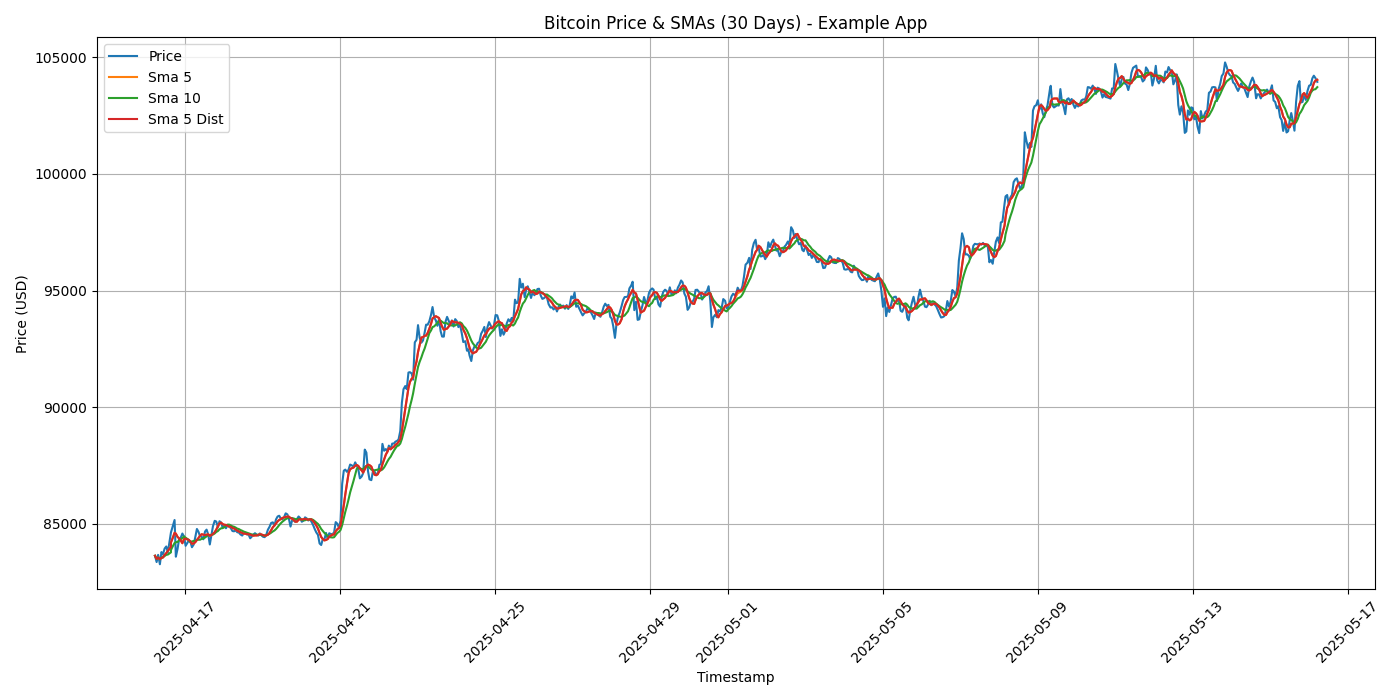

In [7]:
plot_file = None # Initialize
if not analyzed_df.empty:
    print("\nGenerating plot for analyzed data...")
    
    columns_to_plot = ['price', f'sma_{SMA_WINDOW_SHORT}', f'sma_{SMA_WINDOW_LONG}']
    # If the distributed SMA column exists and has data, add it to the plot for comparison
    if DISTRIBUTED_PLOT_COLUMN_NAME in analyzed_df.columns and not analyzed_df[DISTRIBUTED_PLOT_COLUMN_NAME].isnull().all():
        columns_to_plot.append(DISTRIBUTED_PLOT_COLUMN_NAME)
        print(f"Plotting with distributed SMA column: {DISTRIBUTED_PLOT_COLUMN_NAME}")
    else:
        print(f"Distributed SMA column '{DISTRIBUTED_PLOT_COLUMN_NAME}' not available or empty, will not be plotted.")

    plot_file = plot_price_data(analyzed_df,
                                title=f"Bitcoin Price & SMAs ({DAYS_OF_DATA} Days) - Example App",
                                columns_to_plot=columns_to_plot)
    if plot_file:
        print(f"Plot saved to {plot_file}")
        display(Image(filename=plot_file))
    else:
        print("Plotting failed or no valid data to plot.")
else:
    print("\nSkipping visualization as analysis was not performed or failed.")


# Results and Reporting (Storing Final Analysis & Generating Report)


In [8]:
final_report_md = "Analysis could not be completed due to earlier errors or lack of data." # Default message

if analyzed_df is not None and not analyzed_df.empty:
    print(f"\nSerializing final analyzed DataFrame to {ANALYZED_DATA_FILE}...")
    serialize_object(analyzed_df, ANALYZED_DATA_FILE)

    # --- Generating a simple markdown report ---
    report_md_content = f"""# Bitcoin Price Analysis Report (Example Application)

**Analysis Period:** Last {DAYS_OF_DATA} days (Data as of {pd.Timestamp('today', tz='UTC').strftime('%Y-%m-%d %H:%M %Z')})
**Currency:** {CURRENCY}

## Key Findings:
- **Data Points Analyzed:** {len(analyzed_df)}
- **Simple Moving Averages (SMAs) Calculated:**
"""
    temp_report_smas_str = ""
    if f'sma_{SMA_WINDOW_SHORT}' in analyzed_df.columns:
        temp_report_smas_str += f"    - {SMA_WINDOW_SHORT}-day SMA (Standard Method)\n"
    if f'sma_{SMA_WINDOW_LONG}' in analyzed_df.columns:
        temp_report_smas_str += f"    - {SMA_WINDOW_LONG}-day SMA (Standard Method)\n"
    if DISTRIBUTED_PLOT_COLUMN_NAME in analyzed_df.columns and not analyzed_df[DISTRIBUTED_PLOT_COLUMN_NAME].isnull().all():
        temp_report_smas_str += f"    - {SMA_WINDOW_SHORT}-day SMA (Simulated Distributed Method as '{DISTRIBUTED_PLOT_COLUMN_NAME}')\n"
    report_md_content += temp_report_smas_str
    
    report_md_content += f"- **Overall Trend ({DAYS_OF_DATA} days):** {trend_report}\n"
    
    report_md_content += "\n## Visualization:\n"
    if plot_file and os.path.exists(plot_file):
        report_md_content += f"![Bitcoin Price Plot](./{plot_file})\n"
    else:
        report_md_content += "Plot could not be generated or found.\n"

    report_md_content += f"\n\n**Data Storage:**\n"
    if os.path.exists(RAW_DATA_FILE):
        report_md_content += f"- Raw fetched data serialized to: `{RAW_DATA_FILE}`\n"
    # Analyzed data file is always created if this block is reached
    report_md_content += f"- Final analyzed data (with SMAs) serialized to: `{ANALYZED_DATA_FILE}`\n"
    
    report_md_content += "\n**Note on Cloudpickle & Distributed Processing:**\n"
    report_md_content += ("The calculation of one of the SMAs was performed using Python's `multiprocessing` module. "
                          "`cloudpickle` was essential for this, as it allowed the serialization of the `calculate_moving_average` function "
                          "and Pandas DataFrame chunks to be passed to, and results returned from, separate worker processes. "
                          "This demonstrates `cloudpickle`'s utility in enabling more complex, distributed Python workflows.")
    
    final_report_md = report_md_content # Update final_report_md with the full content
    
    print("\n--- Generated Analysis Report ---")
    display(Markdown(final_report_md)) # Display the full report

    # Optionally, save the markdown report to a file
    report_filename = "CloudPickle_Example_Report.md" 
    try:
        with open(report_filename, "w") as f:
            f.write(final_report_md)
        print(f"\nReport content also saved to {report_filename}")
    except Exception as e:
        print(f"Error saving report to file: {e}")
else: # This 'else' is correctly paired with 'if analyzed_df is not None and not analyzed_df.empty:'
    print("\nSkipping final report generation as 'analyzed_df' is empty or None.")
    display(Markdown(final_report_md)) # Display the default "Analysis could not be completed..." message



Serializing final analyzed DataFrame to analyzed_btc_data_30d_example.pkl...
Object successfully serialized to analyzed_btc_data_30d_example.pkl

--- Generated Analysis Report ---


# Bitcoin Price Analysis Report (Example Application)

**Analysis Period:** Last 30 days (Data as of 2025-05-16 05:14 UTC)
**Currency:** usd

## Key Findings:
- **Data Points Analyzed:** 720
- **Simple Moving Averages (SMAs) Calculated:**
    - 5-day SMA (Standard Method)
    - 10-day SMA (Standard Method)
    - 5-day SMA (Simulated Distributed Method as 'sma_5_dist')
- **Overall Trend (30 days):** Simple Trend: Uptrend (Change: 24.29%)

## Visualization:
![Bitcoin Price Plot](./btc_plot_20250516_051410.png)


**Data Storage:**
- Raw fetched data serialized to: `raw_btc_data_30d_example.pkl`
- Final analyzed data (with SMAs) serialized to: `analyzed_btc_data_30d_example.pkl`

**Note on Cloudpickle & Distributed Processing:**
The calculation of one of the SMAs was performed using Python's `multiprocessing` module. `cloudpickle` was essential for this, as it allowed the serialization of the `calculate_moving_average` function and Pandas DataFrame chunks to be passed to, and results returned from, separate worker processes. This demonstrates `cloudpickle`'s utility in enabling more complex, distributed Python workflows.


Report content also saved to CloudPickle_Example_Report.md


# Challenges & Cloudpickle's Role (Recap)

This example highlighted several aspects:
- **Data Ingestion:** Using `requests` and `pandas` for API data.
- **Data Serialization:** `cloudpickle` (via `serialize_object`/`deserialize_object` and direct `dumps`/`loads`) is key for persisting arbitrary Python objects including DataFrames and functions.
- **Time Series Analysis:** Basic SMA and trend analysis with `pandas`.
- **Distributed Processing (Simulated):**
    - `multiprocessing` for parallel execution.
    - `cloudpickle` is crucial for: 
        1. Serializing the analysis function (`calculate_moving_average`) so it can be sent to worker processes.
        2. Serializing the data chunks (Pandas DataFrames) for processing by workers.
        3. Serializing the results from worker processes before sending them back to the main process.
    - Without `cloudpickle`'s ability to handle functions and complex objects robustly, this type of distributed pattern would be much harder to implement with standard `pickle`.
- **Results and Reporting:** Storing processed data and generating dynamic output.

**Challenges in a real distributed setup remain:**
1.  **Dependency Management:** Ensuring all worker nodes have identical Python environments (interpreter, libraries like `pandas`, `numpy`, and `cloudpickle` itself, all with compatible versions).
2.  **Python Version Compatibility:** `cloudpickle` helps, but major Python version differences can still break deserialization.
3.  **Serialization Overhead & Data Transfer:** For very large datasets, the time to serialize, transfer, and deserialize data can negate multiprocessing benefits. Optimized data formats (e.g., Arrow, Parquet) and strategies like shared memory (for local multiprocessing) might be needed.
4.  **Debugging:** More complex in distributed systems. Logging within tasks is essential.

`cloudpickle` addresses the critical need to serialize Python functions and their context, making it a powerful tool for building distributed Python applications.
